In [1]:
import gdown
gdown.download("https://drive.google.com/file/d/1YUbTBFrk9QF0ivR5F640G3dhCMC3XQUZ/view?usp=sharing", "dataset.zip", quiet=False, fuzzy=True)
gdown.extractall("dataset.zip")

Downloading...
From: https://drive.google.com/uc?id=1YUbTBFrk9QF0ivR5F640G3dhCMC3XQUZ
To: /content/dataset.zip
100%|██████████| 1.70G/1.70G [00:28<00:00, 59.1MB/s]


['dataset/',
 'dataset/flooded/',
 'dataset/flooded/0.jpg',
 'dataset/flooded/1.jpg',
 'dataset/flooded/10.jpg',
 'dataset/flooded/100.jpg',
 'dataset/flooded/101.jpg',
 'dataset/flooded/102.jpg',
 'dataset/flooded/103.jpg',
 'dataset/flooded/104.jpg',
 'dataset/flooded/105.jpg',
 'dataset/flooded/106.jpg',
 'dataset/flooded/107.jpg',
 'dataset/flooded/108.jpg',
 'dataset/flooded/109.jpg',
 'dataset/flooded/11.jpg',
 'dataset/flooded/110.jpg',
 'dataset/flooded/111.jpg',
 'dataset/flooded/112.jpg',
 'dataset/flooded/113.jpg',
 'dataset/flooded/114.jpg',
 'dataset/flooded/115.jpg',
 'dataset/flooded/116.jpg',
 'dataset/flooded/117.jpg',
 'dataset/flooded/118.jpg',
 'dataset/flooded/119.jpg',
 'dataset/flooded/12.jpg',
 'dataset/flooded/120.jpg',
 'dataset/flooded/121.jpg',
 'dataset/flooded/122.jpg',
 'dataset/flooded/123.jpg',
 'dataset/flooded/124.jpg',
 'dataset/flooded/125.jpg',
 'dataset/flooded/126.jpg',
 'dataset/flooded/127.jpg',
 'dataset/flooded/128.jpg',
 'dataset/flooded/129

In [2]:
import os
import logging
from typing import Tuple, Dict, List

import numpy as np
import pandas as pd
from scipy.cluster import vq

from PIL import Image
from osgeo import gdal
from osgeo import gdalconst
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)


In [3]:
# ISOData Algorithm
class ISOData:
    def __init__(self, img: np.ndarray, config: Dict):
        self.img = img
        self.img_flat = img.flatten()
        self.config = config
        # TODO: cache the img_class_flat as well
        self.__init_params()

    def __init_params(self) -> None:
        """
        Initialize the parameters for the algorithm using the config file.
        """
        self.K = self.config.get("K", 5)  # number of clusters desired.
        self.ITERS = self.config.get("ITERS", 100)  # max number of iterations.
        self.P = self.config.get("P", 4)  # max number of pairs of clusters which can be merged.
        self.THETA_M = self.config.get("THETA_M", 10)  # min number of samples in each cluster. (or discard)
        self.THETA_S = self.config.get("THETA_S", 1)  # standard deviation (for split).
        self.THETA_C = self.config.get("THETA_C", 20)  # pairwise distances (for merge).
        self.THETA_O = self.config.get("THETA_O", 0.05)  # min change in the clusters between each iter. (for convergence)
        self.nstarting_clusters = self.config.get("nstarting_clusters", self.K)  # number of starting clusters.
        self.method = self.config.get("method", "linspace")  # method for initial cluster centers.

    def run(self) -> np.ndarray:
        """
        Run the ISOData Classification algorithm.
        """
        n, m = self.img.shape
        k = self.nstarting_clusters
        iter = 0
        centers = self.__init_clusters()
        clusters_list = np.arange(k)  # number of clusters availables
        img_class_flat, _ = vq.vq(self.img_flat, centers)
        print(f"Starting ISOData with {self.nstarting_clusters} clusters.")
        while iter < self.ITERS:
            print(f"{iter=}")
            prev_centers = centers.copy()
            img_class_flat, _ = vq.vq(self.img_flat, centers)
            centers, clusters_list = self.__discard_clusters(img_class_flat, centers, clusters_list)
            centers, clusters_list = self.__update_clusters_centers(img_class_flat, centers, clusters_list)
            k = centers.size
            if k <= (self.K / 2.0): # too few clusters, split
                centers, clusters_list = self.__split_clusters(img_class_flat, centers, clusters_list)
            elif k >= (self.K * 2.0): # too many clusters, merge
                centers, clusters_list = self.__merge_clusters(img_class_flat, centers, clusters_list)
            else: # nor split nor merge needed
                pass
            k = centers.size
            if self.__is_low_cluster_change(prev_centers, centers):
                break 
            iter += 1
        print(f"ISOData finished with {k} clusters. in {iter+1} iterations.")
        return img_class_flat.reshape(n, m)

    def __init_clusters(self) -> np.ndarray:
        """
        Initialize the clusters centers.
        Returns:
            np.ndarray: centers of the clusters.
        """
        if self.method == "linspace":
            max, min = self.img_flat.max(), self.img_flat.min()
            centers = np.linspace(min, max, self.nstarting_clusters)
        elif self.method == "random":
            start, end = 0, self.img_flat.size
            indices = np.random.randint(start, end, self.nstarting_clusters)
            centers = self.img_flat.take(indices)
        else:
            raise ValueError("Invalid method for initial cluster centers.")
        return centers

    def __check_sizes(self, centers: np.ndarray, clusters_list: np.ndarray) -> None:
        if centers.size != clusters_list.size:
            raise ValueError("centers and clusters_list must have the same size.")


    def __is_low_cluster_change(self, prev_centers: np.ndarray, cur_centers: np.ndarray) -> bool:
        """
        Check the change in clusters centers between two iterations if it's below a threshold or not.
        Args:
            prev_centers (np.ndarray): centers of the clusters in the previous iteration.
            cur_centers (np.ndarray): centers of the clusters in the current iteration.
        Returns:
            bool: True if the change in clusters centers is below the threshold, False otherwise.
        """
        low_change = False
        if prev_centers.shape == cur_centers.shape:
            thresholds = np.abs((cur_centers - prev_centers) / (prev_centers + 1))
            if np.all(thresholds <= self.THETA_O):
                low_change = True
        return low_change

    def __sort_by_first(self, centers: np.ndarray, clusters_list: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Sort the clusters centers and clusters list by the centers values.
        Args:
            centers (np.ndarray): centers of the clusters.
            clusters_list (np.ndarray): list of clusters.
        Returns:
            Tuple[np.ndarray, np.ndarray]: sorted centers and sorted clusters list.
        Examples:
            >>> centers = np.array([1, 3, 2])
            >>> clusters_list = np.array([0, 1, 2])
            >>> sorted_centers, sorted_clusters_list = self.__sort_by_first(centers, clusters_list)
            >>> sorted_centers
            array([1, 2, 3])
            >>> sorted_clusters_list
            array([0, 2, 1])
        """
        self.__check_sizes(centers, clusters_list)
        sorted_indices = np.argsort(centers)
        sorted_centers = centers[sorted_indices]
        sorted_clusters_list = clusters_list[sorted_indices]
        return sorted_centers, sorted_clusters_list

    def __compute_avg_distances(self, img_class_flat: np.ndarray, centers: np.ndarray, clusters_list: np.ndarray) -> np.ndarray:
        """
        Compute the average distances between to the center of each cluster.
        Args:
            img_class_flat (np.ndarray): class of each pixel in the image.
            centers (np.ndarray): centers of the clusters.
            clusters_list (np.ndarray): list of clusters.
        Returns:
            np.ndarray: average distances between each cluster and its points.
        """
        k = centers.size
        avg_dists_to_clusters = np.array([])
        for cluster in range(k):
            indicies = np.where(img_class_flat == clusters_list[cluster])[0]
            total_per_cluster = indicies.size + 1
            sum_per_cluster = np.sum(np.abs(self.img_flat[indicies] - centers[cluster]))
            dist = sum_per_cluster / float(total_per_cluster)
            avg_dists_to_clusters = np.append(avg_dists_to_clusters, dist)
        return avg_dists_to_clusters

    def __compute_overall_distance(
        self,
        img_class_flat: np.ndarray,
        avg_dists_to_clusters: np.ndarray,
        clusters_list: np.ndarray,
    ) -> np.float_:
        """
        Compute the overall distance between the clusters and their points.
        Args:
            img_class_flat (np.ndarray): class of each pixel in the image.
            avg_dists_to_clusters (np.ndarray): average distances between each cluster and its points.
            clusters_list (np.ndarray): list of clusters.
        Returns:
            np.float_: overall distance between the clusters and their points.
        """
        k = avg_dists_to_clusters.size
        total = img_class_flat.size
        count_per_cluster = np.zeros(k)
        for cluster in range(k):
            indicies = np.where(img_class_flat == clusters_list[cluster])[0]
            count_per_cluster[cluster] = indicies.size
        dist = ((count_per_cluster / total) * avg_dists_to_clusters).sum()
        return dist

    def __compute_pairwise_distances(self, centers: np.ndarray) -> List[Tuple[np.float_, Tuple[int, int]]]:
        """
        Compute the pairwise distances between the centers of the clusters.
        Args:
            centers (np.ndarray): centers of the clusters.
        Returns:
            numpy array of tuples: each tuple contains the distance between two clusters and the indices of the clusters.
            like [(distance, cluster1, cluster2), ...]
        """
        pair_dists = []
        size = centers.size
        for i in range(0, size):
            for j in range(0, size):
                if i > j:
                    d = np.abs(centers[i] - centers[j])
                    pair_dists.append((d, (i, j)))
        return sorted(pair_dists);

    def __update_clusters_centers(
        self, img_class_flat: np.ndarray, centers: np.ndarray, clusters_list: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Update the centers of the clusters.
        Args:
            img_class_flat (np.ndarray): the image with the clusters.
            centers (np.ndarray): centers of the clusters.
            clusters_list (np.ndarray): list of clusters.
        Returns:
            Tuple[np.ndarray, np.ndarray]: updated centers and updated clusters list.
        """
        k = centers.shape[0]
        new_centers = np.array([])
        new_clusters_list = np.array([])
        self.__check_sizes(centers, clusters_list)
        for cluster in range(0, k):
            indices = np.where(img_class_flat == clusters_list[cluster])[0]
            cluster_values = self.img_flat[indices]
            sum_per_cluster = cluster_values.sum()
            total_per_cluster = (cluster_values.size) + 1
            new_cluster = sum_per_cluster / total_per_cluster
            new_centers = np.append(new_centers, new_cluster)
            new_clusters_list = np.append(new_clusters_list, cluster)
        new_centers, new_clusters_list = self.__sort_by_first(new_centers, new_clusters_list)
        self.__check_sizes(new_centers, new_clusters_list)
        return new_centers, new_clusters_list

    def __discard_clusters(
        self, img_class_flat: np.ndarray, centers: np.ndarray, clusters_list: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Discard clusters that have less than THETA_M classes
        Args:
            img_class_flat (np.ndarray): the image with the clusters.
            centers (np.ndarray): centers of the clusters.
            clusters_list (np.ndarray): list of clusters.
        """
        k = centers.shape[0]
        to_discard = np.array([])
        self.__check_sizes(centers, clusters_list)
        for cluster in range(k):
            indicies = np.where(img_class_flat == clusters_list[cluster])[0]
            total_per_cluster = indicies.size 
            if total_per_cluster <= self.THETA_M:
                to_discard = np.append(to_discard, cluster)
        if to_discard.size:
            new_centers = np.delete(centers, to_discard)
            new_clusters_list = np.delete(clusters_list, to_discard)
        else:
            new_centers = centers
            new_clusters_list = clusters_list
        new_centers, new_clusters_list = self.__sort_by_first(new_centers, new_clusters_list)
        self.__check_sizes(new_centers, new_clusters_list)
        return new_centers, new_clusters_list

    def __split_clusters(
        self,
        img_class_flat: np.ndarray,
        centers: np.ndarray,
        clusters_list: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Split clusters that have more than THETA_S classes into two clusters and 
        update the centers and clusters list.
        Args:
            img_class_flat (np.ndarray): the image with the clusters.
            centers (np.ndarray): centers of the clusters.
            clusters_list (np.ndarray): list of clusters.
        Returns:
            Tuple[np.ndarray, np.ndarray]: updated centers and updated clusters list.
        """
        delta = 10
        k = centers.size
        count_per_cluster = np.zeros(k)
        stddev = np.array([])
        avg_dists_to_clusters = self.__compute_avg_distances(img_class_flat, centers, clusters_list)
        d = self.__compute_overall_distance(img_class_flat, avg_dists_to_clusters, clusters_list)
        for cluster_idx in range(k):
            indicies = np.where(img_class_flat == clusters_list[cluster_idx])[0]
            count_per_cluster[cluster_idx] = indicies.size
            cur_stddev = ((self.img_flat[indices] - centers[cluster_idx]) ** 2).sum()
            cur_stddev /= count_per_cluster[cluster_idx]
            cur_stddev = np.sqrt(cur_stddev)
            stddev = np.append(stddev, cur_stddev)
        cluster_idx = np.argmax(stddev)
        max_stddev = stddev[cluster_idx]
        max_cluster_list = int(clusters_list.max())
        if max_stddev > self.THETA_S:
            if avg_dists_to_clusters[cluster_idx] >= d:
                if count_per_cluster[cluster_idx] >= (2.0 * self.THETA_M):
                    old_cluster_center = centers[cluster_idx]
                    new_cluster_center_1 = old_cluster_center + delta
                    new_cluster_center_2 = old_cluster_center - delta
                    centers = np.delete(centers, cluster_idx)
                    clusters_list = np.delete(clusters_list, cluster_idx)
                    centers = np.append(centers, [new_cluster_center_1, new_cluster_center_2])
                    clusters_list = np.append(clusters_list, [max_cluster_list, (max_cluster_list+1)])
                    centers, clusters_list = self.__sort_by_first(centers, clusters_list)
                    self.__check_sizes(centers, clusters_list)
        return centers, clusters_list

    def __merge_clusters(
        self,
        img_class_flat: np.ndarray,
        centers: np.ndarray,
        clusters_list: np.ndarray,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Merge clusters that are close to each other i.e the distance between them is less than THETA_C.
        Args:
            img_class_flat (np.ndarray): the image with the cluster indices.
            centers (np.ndarray): centers of the clusters.
            clusters_list (np.ndarray): list of the clusters.
        Returns:
            Tuple[np.ndarray, np.ndarray]: the new centers and clusters_list after merging.
        """
        pairwise_dists = self.__compute_pairwise_distances(centers)
        first_p_elements = pairwise_dists[:self.P]
        below_theta = [(c1, c2) for d, (c1, c2) in first_p_elements if d < self.THETA_C]
        if below_theta:
            k = centers.size
            count_per_cluster = np.zeros(k)
            to_add = np.array([])
            to_remove = np.array([])
            for cluster in range(k):
                indicies = np.where(img_class_flat == clusters_list[cluster])[0]
                count_per_cluster[cluster] = indicies.size
            for c1, c2 in below_theta:
                c1_count = float(count_per_cluster[c1]) + 1
                c2_count = float(count_per_cluster[c2])
                factor = 1.0 / (c1_count + c2_count)
                weight_c1 = c1_count * centers[c1]
                weight_c2 = c2_count * centers[c2]

                new_center = np.round(factor * (weight_c1 + weight_c2))

                to_add = np.append(to_add, new_center)
                to_remove = np.append(to_remove, [c1, c2])

            centers = np.delete(centers, to_remove)
            clusters_list = np.delete(clusters_list, to_remove)
            start_idx = int(clusters_list.max()) # + 1
            end_idx = start_idx + to_add.size
            centers = np.append(centers, to_add)
            clusters_list = np.append(clusters_list, np.arange(start_idx, end_idx))
            centers, clusters_list = self.__sort_by_first(centers, clusters_list)
        return centers, clusters_list


Starting ISOData with 2 clusters.
iter=0
iter=1
iter=2
ISOData finished with 2 clusters. in 3 iterations.


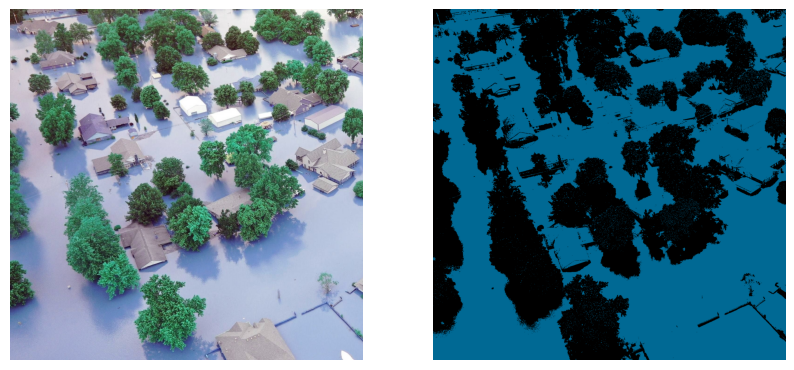

Starting ISOData with 2 clusters.
iter=0
iter=1
iter=2
iter=3
iter=4
ISOData finished with 2 clusters. in 5 iterations.


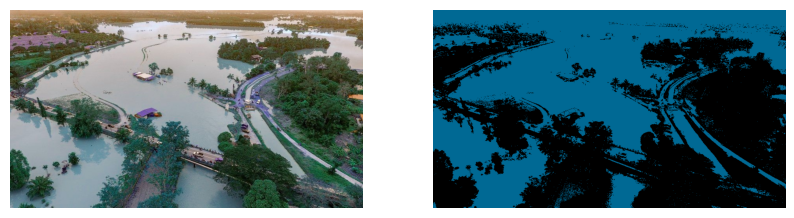

Starting ISOData with 2 clusters.
iter=0
iter=1
iter=2
iter=3
iter=4
iter=5
iter=6
iter=7
ISOData finished with 2 clusters. in 8 iterations.


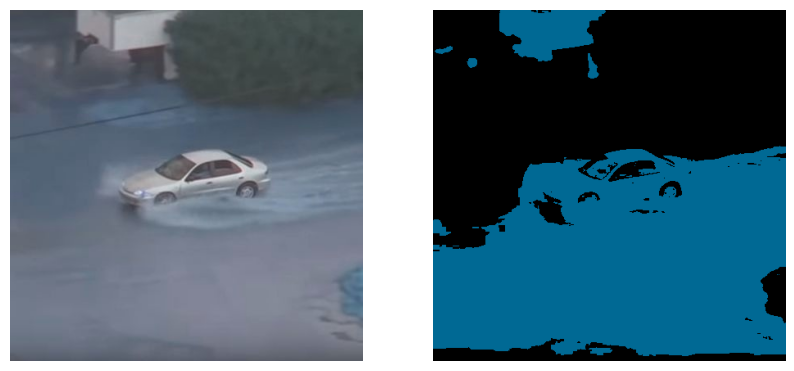

Starting ISOData with 2 clusters.
iter=0
iter=1
iter=2
iter=3
iter=4
iter=5
ISOData finished with 2 clusters. in 6 iterations.


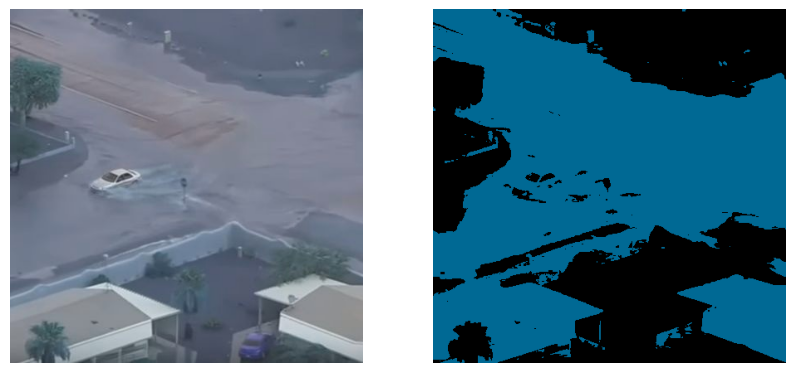

In [6]:
config = {
    "K": 2,                         # number of clusters desired.
    "ITERS": 10000,                 # max number of iterations.
    "P": 2,                         # max number of pairs of clusters which can be merged.
    "THETA_M": 60,                  # min number of samples in each cluster.
    "THETA_S": 4.5,                   # standard deviation (for split).
    "THETA_C": 3,                  # pairwise distances (for merge).
    "THETA_O": 0.01,                # min change in the clusters between each iter.
}

img_path_folder = "/content/dataset/flooded/"
img_list = [0, 102, 116, 10]

for img_idx in img_list:
    img = gdal.Open(img_path_folder + str(img_idx) + ".jpg")
    img = img.ReadAsArray()
    one_band = img[0]
    algo = ISOData(one_band, config)
    clusterd_img = algo.run()
    # clusted_img has 2 clusters one for water and one for non-water
    # show the one for water in RGB = 0, 105, 148 and the other in black
    # larger_cluster = 0 if np.sum(clusterd_img == 0) > np.sum(clusterd_img == 1) else 1
    r = clusterd_img.copy()
    g = clusterd_img.copy()
    b = clusterd_img.copy()
    r[clusterd_img == 1] = 0
    g[clusterd_img == 1] = 105
    b[clusterd_img == 1] = 148
    final_img = np.zeros((clusterd_img.shape[0], clusterd_img.shape[1], 3))
    final_img[:, :, 0] = r
    final_img[:, :, 1] = g
    final_img[:, :, 2] = b
    final_img = final_img.astype(np.uint8)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].imshow(img.transpose(1, 2, 0))
    axs[0].axis('off')
    axs[1].imshow(final_img)
    axs[1].axis('off')
    plt.show()